# Custom Gymnasium Mujoco Env
参考：[test_mujoco_custom_env.py](https://github.com/Farama-Foundation/Gymnasium/blob/main/tests/envs/mujoco/test_mujoco_custom_env.py)

オリジナルのMuJoCo環境を作成します

オリジナルのMuJoCo環境は，そのクラスを作ることで実装します．
実査の学習を行うmain文的な処理は，gymのインターフェースであれば共通で使用できます．
よって，自分なりの環境クラスを作成すればいいだけです．
その環境クラスには，step, reset, render,などの必須なメソッドを定義する必要がありますが，MuJoCoでは使いやすくするためのサンプルがあります！
よってそれを元に作るだけで，強化学習の環境が作れて，学習を回すことができます

In [1]:
__credits__ = ["Kallinteris-Andreas"]

import os
import warnings

import numpy as np
import pytest

from gymnasium import utils
from gymnasium.envs.mujoco import MujocoEnv
from gymnasium.error import Error
from gymnasium.spaces import Box
from gymnasium.utils.env_checker import check_env


class MouseEnv(MujocoEnv, utils.EzPickle):
    """
    Gymansium.MujocoEnv`環境APIを使った，マイクロマウスの強化学習環境\n
    まずは前進し続ける動作を行う環境を作成します．\n
    mujoco envを継承しています．
    """

    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "depth_array",
        ],
    }

    def __init__(self, xml_file="my_xmls/mouse_in_maze.xml", frame_skip=1, **kwargs):
        utils.EzPickle.__init__(self, xml_file, frame_skip, **kwargs)

        MujocoEnv.__init__(
            self,
            xml_file,
            frame_skip=frame_skip,
            observation_space=None,  # needs to be defined after
            default_camera_config={},
            **kwargs,
        )

        self.metadata = {
            "render_modes": [
                "human",
                "rgb_array",
                "depth_array",
            ],
            "render_fps": int(np.round(1.0 / self.dt)),
        }

        obs_size = self.data.qpos.size + self.data.qvel.size #たとえば，観測空間に位置と速度を入れたいのであれば，サイズを指定したいので，サイズを取る

        self.observation_space = Box(
            low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float64
        )

    def step(self, action):
        x_position_before = self.data.qpos[0]
        self.do_simulation(action, self.frame_skip)
        x_position_after = self.data.qpos[0]

        observation = self._get_obs()
        reward = x_position_after - x_position_before
        info = {}

        if self.render_mode == "human":
            self.render()
        return observation, reward, False, False, info

    def _get_obs(self): #状態空間を取得
        position = self.data.qpos.flat.copy()
        velocity = self.data.qvel.flat.copy()
        return np.concatenate((position, velocity)) #npの値を連結して返す．これが状態空間となる

    def reset_model(self):
        qpos = self.init_qpos
        qvel = self.init_qvel
        self.set_state(qpos, qvel)

        observation = self._get_obs()

        return observation

    def _get_reset_info(self):
        return {"works": True}


CHECK_ENV_IGNORE_WARNINGS = [
    f"\x1b[33mWARN: {message}\x1b[0m"
    for message in [
        "A Box observation space minimum value is -infinity. This is probably too low.",
        "A Box observation space maximum value is infinity. This is probably too high.",
        "For Box action spaces, we recommend using a symmetric and normalized space (range=[-1, 1] or [0, 1]). See https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html for more information.",
    ]
]


@pytest.mark.parametrize("frame_skip", [1, 2, 3, 4, 5])
def test_frame_skip(frame_skip):
    """verify that custom envs work with different `frame_skip` values"""
    env = MouseEnv(frame_skip=frame_skip)

    # Test if env adheres to Gym API
    with warnings.catch_warnings(record=True) as w:
        check_env(env.unwrapped, skip_render_check=True)
        env.close()
    for warning in w:
        if warning.message.args[0] not in CHECK_ENV_IGNORE_WARNINGS:
            raise Error(f"Unexpected warning: {warning.message}")


def test_xml_file():
    """Verify that the loading of a custom XML file works"""
    relative_path = "./tests/envs/mujoco/assets/walker2d_v5_uneven_feet.xml"
    env = MouseEnv(xml_file=relative_path).unwrapped
    assert isinstance(env, MujocoEnv)
    assert env.data.qpos.size == 9

    full_path = os.getcwd() + "/tests/envs/mujoco/assets/walker2d_v5_uneven_feet.xml"
    env = MouseEnv(xml_file=full_path).unwrapped
    assert isinstance(env, MujocoEnv)
    assert env.data.qpos.size == 9

    # note can not test user home path (with '~') because github CI does not have a home folder


def test_reset_info():
    """Verify that the environment returns info at `reset()`"""
    env = MouseEnv()

    _, info = env.reset()
    assert info["works"] is True

# デベロップ

オドメトリなしの小さめ構成の環境　視認性

In [2]:
__credits__ = ["Kallinteris-Andreas"]

import os
import warnings

import numpy as np
import pytest

from gymnasium import utils
from gymnasium.envs.mujoco import MujocoEnv
from gymnasium.error import Error
from gymnasium.spaces import Box
from gymnasium.utils.env_checker import check_env


class MouseEnv(MujocoEnv, utils.EzPickle):
    """
    Gymansium.MujocoEnv`環境APIを使った，マイクロマウスの強化学習環境\n
    まずは前進し続ける動作を行う環境を作成します．\n
    mujoco envを継承しています．
    """

    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "depth_array",
        ],
    }

    def __init__(self, xml_file="my_xmls/mouse_in_maze_for_3_light.xml", frame_skip=1, **kwargs):
        utils.EzPickle.__init__(self, xml_file, frame_skip, **kwargs)

        MujocoEnv.__init__(
            self,
            xml_file,
            frame_skip=frame_skip,
            observation_space=None,  # needs to be defined after
            default_camera_config={},
            **kwargs,
        )

        self.metadata = {
            "render_modes": [
                "human",
                "rgb_array",
                "depth_array",
            ],
            "render_fps": int(np.round(1.0 / self.dt)),
        }

        obs_size = 14 #self.data.qpos.size + self.data.qvel.size #たとえば，観測空間に位置と速度を入れたいのであれば，サイズを指定したいので，サイズを取る
        # self.wall_hit = 0
        self.reward_graph = []

        self.observation_space = Box(
            low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float64
        )

    def step(self, action):
        wall_hit = 0
        velocity_before = self.data.sensor("Veloci").data[0] # 前の速度を取る

        self.do_simulation(action, self.frame_skip)
        velocity_after = self.data.sensor("Veloci").data[0] # 今の速度を取る
        mouse_vel = velocity_after - velocity_before

        ls = self.data.sensor('LS').data[0]#sensordata[ls_id]
        rs = self.data.sensor('RS').data[0]#sensordata[rs_id]
        center_sensor = ls - rs

        hit_wall_f = self.data.sensor("HB1").data[0] #フォースセンサの値取得
        hit_wall_b = self.data.sensor("HB2").data[0] #フォースセンサの値取得
        truncated = False
        # print("hit wall", hit_wall_f, hit_wall_b)
        if hit_wall_f > 0 or hit_wall_b > 0:
            # self.wall_hit = -10
            wall_hit = -10
            print("hit wall", hit_wall_f, hit_wall_b)
            truncated = True

        observation = self._get_obs()
        reward = 10*(mouse_vel) + 0*(center_sensor) + wall_hit #self.wall_hitにしないほうが見通しが良い気がする
        self.reward_graph.append(reward)
        info = {}

        if self.render_mode == "human":
            self.render()
        return observation, reward, False, truncated, info

    def _get_obs(self): #状態空間を取得
        position = self.data.qpos.flat.copy()
        velocity = self.data.sensor("Veloci").data[0] # 今の速度を取る
        lf = self.data.sensor('LF').data[0]#sensordata[lf_id]
        ls = self.data.sensor('LS').data[0]#sensordata[ls_id]
        rs = self.data.sensor('RS').data[0]#sensordata[rs_id]
        rf = self.data.sensor('RF').data[0]#sensordata[rf_id]
        # 0次元配列（スカラー）を1次元配列に変換
        velocity = np.array([velocity])
        lf = np.array([lf])
        ls = np.array([ls])
        rs = np.array([rs])
        rf = np.array([rf])

        # # 結合
        # observation = np.concatenate((position, velocity, lf, ls, rs, rf))

        return np.concatenate((position, velocity, lf, ls, rs, rf)) #npの値を連結して返す．これが状態空間となる

    def reset_model(self):
        qpos = self.init_qpos
        qvel = self.init_qvel
        self.set_state(qpos, qvel)

        observation = self._get_obs()

        return observation

    def _get_reset_info(self):
        return {"works": True}
    
    # def _get_distance(model, data):
    #     lf = data.sensor('LF').data[0]#sensordata[lf_id]
    #     ls = data.sensor('LS').data[0]#sensordata[ls_id]
    #     rs = data.sensor('RS').data[0]#sensordata[rs_id]
    #     rf = data.sensor('RF').data[0]#sensordata[rf_id]
    #     return lf,ls,rs,rf


CHECK_ENV_IGNORE_WARNINGS = [
    f"\x1b[33mWARN: {message}\x1b[0m"
    for message in [
        "A Box observation space minimum value is -infinity. This is probably too low.",
        "A Box observation space maximum value is infinity. This is probably too high.",
        "For Box action spaces, we recommend using a symmetric and normalized space (range=[-1, 1] or [0, 1]). See https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html for more information.",
    ]
]


@pytest.mark.parametrize("frame_skip", [1, 2, 3, 4, 5])
def test_frame_skip(frame_skip):
    """verify that custom envs work with different `frame_skip` values"""
    env = MouseEnv(frame_skip=frame_skip)

    # Test if env adheres to Gym API
    with warnings.catch_warnings(record=True) as w:
        check_env(env.unwrapped, skip_render_check=True)
        env.close()
    for warning in w:
        if warning.message.args[0] not in CHECK_ENV_IGNORE_WARNINGS:
            raise Error(f"Unexpected warning: {warning.message}")


def test_xml_file():
    """Verify that the loading of a custom XML file works"""
    relative_path = "./tests/envs/mujoco/assets/walker2d_v5_uneven_feet.xml"
    env = MouseEnv(xml_file=relative_path).unwrapped
    assert isinstance(env, MujocoEnv)
    assert env.data.qpos.size == 9

    full_path = os.getcwd() + "/tests/envs/mujoco/assets/walker2d_v5_uneven_feet.xml"
    env = MouseEnv(xml_file=full_path).unwrapped
    assert isinstance(env, MujocoEnv)
    assert env.data.qpos.size == 9

    # note can not test user home path (with '~') because github CI does not have a home folder


def test_reset_info():
    """Verify that the environment returns info at `reset()`"""
    env = MouseEnv()

    _, info = env.reset()
    assert info["works"] is True

## 状態にオドメトリによる座標を追加

In [3]:
__credits__ = ["Kallinteris-Andreas"]

import os
import warnings

import math
import numpy as np
import pytest

from gymnasium import utils
from gymnasium.envs.mujoco import MujocoEnv
from gymnasium.error import Error
from gymnasium.spaces import Box
from gymnasium.utils.env_checker import check_env


class MouseEnv(MujocoEnv, utils.EzPickle):
    """
    Gymansium.MujocoEnv`環境APIを使った，マイクロマウスの強化学習環境\n
    まずは前進し続ける動作を行う環境を作成します．\n
    mujoco envを継承しています．
    """

    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "depth_array",
        ],
    }

    def __init__(self, xml_file="my_xmls/mouse_in_maze.xml", frame_skip=1, **kwargs):
        utils.EzPickle.__init__(self, xml_file, frame_skip, **kwargs)

        MujocoEnv.__init__(
            self,
            xml_file,
            frame_skip=frame_skip,
            observation_space=None,  # needs to be defined after
            default_camera_config={},
            **kwargs,
        )

        self.metadata = {
            "render_modes": [
                "human",
                "rgb_array",
                "depth_array",
            ],
            "render_fps": int(np.round(1.0 / self.dt)),
        }

        obs_size = 17 #self.data.qpos.size + self.data.qvel.size #たとえば，観測空間に位置と速度を入れたいのであれば，サイズを指定したいので，サイズを取る
        # self.wall_hit = 0
        #マイクロマウスのパラメータ用変数
        self.reward_graph = []
        self.mouse_xpos_graph = []
        self.mouse_ypos_graph = []
        self.mouse_angle_rad = math.pi/2
        self.mouse_xpos = 0
        self.mouse_ypos = 0
        self.now_time = 0
        self.past_time = 0
        self.delta_t = 0
        self.wheel_r = 0
        self.gear = 9.0e-3
        self.wheel_r = 0.0135
        self.tread = 0.072
        self.right_rotation_sum = 0
        self.left_rotation_sum = 0
        


        self.observation_space = Box(
            low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float64
        )

    def get_odom(self, model, data): #今のタイヤの回転角度と速度（角度と角速度）を求める．
        odm_right = data.actuator('right').length[0]/self.gear # 得た値をgearで割ったもの＝タイヤの角度(rad)
        odm_left = data.actuator('left').length[0]/self.gear # ＝タイヤの角度
        vel_left = data.actuator('left').velocity[0]/self.gear # ＝タイヤの回転角速度
        return odm_right, odm_left
    
    def get_pulse_count(self, pre_odm_right, pre_odm_left, odm_right, odm_left): #回転量をパルスにする エンコーダの役割をする関数
        """
            回転量の差から，パルス数を求める． エンコーダの役割をする関数\\
            Returns:
                right_pulse_num = 右タイヤのパルス数 \\
                left_pulse_num = 左タイヤのパルス数
            """
        
        pre_right_rotation_sum = self.right_rotation_sum
        pre_left_rotation_sum = self.left_rotation_sum
        self.right_rotation_sum += (odm_right - pre_odm_right)/(2*math.pi) *4096 #1周あたり4096段階で，細かい回転量を計測（分解能ほぼ無限のエンコーダ）
        self.left_rotation_sum += (odm_left - pre_odm_left)/(2*math.pi) *4096 #1周あたり4096段階で，細かい回転量を計測（分解能ほぼ無限のエンコーダ）
        right_pulse_num = int(self.right_rotation_sum) - int(pre_right_rotation_sum)
        left_pulse_num = int(self.left_rotation_sum) - int(pre_left_rotation_sum)
        # print("回転量をパルス段階に変換　この値の差が，実際に出たパルスとなる：", right_pulse_num)
        return right_pulse_num, left_pulse_num
    
    def get_odom_at_pulse(self, right_pulse_num, left_pulse_num): #今のタイヤの回転角度と速度（角度と角速度）を求める．
        right_wheel_move = 2*math.pi * self.wheel_r * (right_pulse_num/4096) #２πｒ×回転数で移動距離を求める．/delta_t
        left_wheel_move = 2*math.pi * self.wheel_r * (left_pulse_num/4096) #２πｒ×回転数で移動距離を求める．
        right_wheel_vel = right_wheel_move/self.delta_t #移動距離から，速度を求める
        left_wheel_vel = left_wheel_move/self.delta_t #移動距離から，速度を求める
        mouse_vel = (right_wheel_vel + left_wheel_vel)/2 #左右平均が並進速度
        mouse_radvel = (right_wheel_vel - left_wheel_vel)/self.tread #これがマウスの旋回角速度（rad/s）
        return mouse_vel, mouse_radvel #これで，エンコーダによる各タイヤの推定速度が求められた

    def step(self, action):
        wall_hit = 0
        velocity_before = self.data.sensor("Veloci").data[0] # 前の速度を取る
        ####オドメトリ####
        self.past_time = self.data.time
        # エンコーダを読み取る
        pre_odm_right, pre_odm_left = self.get_odom(self.model, self.data)

        self.do_simulation(action, self.frame_skip)####################シミュレーション実行##############################
        self.now_time = self.data.time
        self.delta_t = self.now_time - self.past_time #シミュレーションが1ステップ終わった後の時間を取得
        self.past_time = self.now_time
        # エンコーダをもう一度読み取る　（行動後の値を取得）
        odm_right, odm_left = self.get_odom(self.model, self.data)
        # エンコーダ値から，この一瞬に出たパルス数を算出し，
        right_pulse_num, left_pulse_num = self.get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
        # パルス数から，移動速度と角速度を求める
        mouse_vel, mouse_rad_vel = self.get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
        # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
        self.mouse_angle_rad += mouse_rad_vel * self.delta_t #マウスの角速度はパルスの左右差で求められるので，現在の角度は
        # print("関数内は：", mouse_angle_rad)
        self.mouse_xpos += mouse_vel * math.cos(self.mouse_angle_rad) * self.delta_t #オドメトリで座標推定
        self.mouse_ypos += mouse_vel * math.sin(self.mouse_angle_rad) * self.delta_t
        self.mouse_xpos_graph.append(self.mouse_xpos)
        self.mouse_ypos_graph.append(self.mouse_ypos)
        ####オドメトリ####

        velocity_after = self.data.sensor("Veloci").data[0] # 今の速度を取る
        mouse_vel = velocity_after - velocity_before

        ls = self.data.sensor('LS').data[0]#sensordata[ls_id]
        rs = self.data.sensor('RS').data[0]#sensordata[rs_id]
        center_sensor = ls - rs

        hit_wall_f = self.data.sensor("HB1").data[0] #フォースセンサの値取得
        hit_wall_b = self.data.sensor("HB2").data[0] #フォースセンサの値取得
        truncated = False
        # print("hit wall", hit_wall_f, hit_wall_b)
        if hit_wall_f > 0 or hit_wall_b > 0:
            # self.wall_hit = -10
            wall_hit = -10
            # print("hit wall", hit_wall_f, hit_wall_b)
            truncated = True

        observation = self._get_obs()
        reward = 10*(mouse_vel) + 0*(center_sensor) + wall_hit #self.wall_hitにしないほうが見通しが良い気がする
        self.reward_graph.append(reward)
        info = {}

        if self.render_mode == "human":
            self.render()
        return observation, reward, False, truncated, info

    def _get_obs(self): #状態空間を取得
        position = self.data.qpos.flat.copy()
        velocity = self.data.sensor("Veloci").data[0] # 今の速度を取る
        lf = self.data.sensor('LF').data[0]#sensordata[lf_id]
        ls = self.data.sensor('LS').data[0]#sensordata[ls_id]
        rs = self.data.sensor('RS').data[0]#sensordata[rs_id]
        rf = self.data.sensor('RF').data[0]#sensordata[rf_id]
        mouse_angle_rad = np.array([self.mouse_angle_rad])
        mouse_xpos = np.array([self.mouse_xpos])
        mouse_ypos = np.array([self.mouse_ypos])
        # 0次元配列（スカラー）を1次元配列に変換
        velocity = np.array([velocity])
        lf = np.array([lf])
        ls = np.array([ls])
        rs = np.array([rs])
        rf = np.array([rf])

        # # 結合
        # observation = np.concatenate((position, velocity, lf, ls, rs, rf))

        return np.concatenate((position, velocity, lf, ls, rs, rf, mouse_angle_rad, mouse_xpos, mouse_ypos)) #npの値を連結して返す．これが状態空間となる

    def reset_model(self):
        qpos = self.init_qpos
        qvel = self.init_qvel
        self.set_state(qpos, qvel)
        self.mouse_angle_rad = 0
        self.mouse_xpos = 0
        self.mouse_ypos = 0

        observation = self._get_obs()

        return observation

    def _get_reset_info(self):
        return {"works": True}
    
    # def _get_distance(model, data):
    #     lf = data.sensor('LF').data[0]#sensordata[lf_id]
    #     ls = data.sensor('LS').data[0]#sensordata[ls_id]
    #     rs = data.sensor('RS').data[0]#sensordata[rs_id]
    #     rf = data.sensor('RF').data[0]#sensordata[rf_id]
    #     return lf,ls,rs,rf


CHECK_ENV_IGNORE_WARNINGS = [
    f"\x1b[33mWARN: {message}\x1b[0m"
    for message in [
        "A Box observation space minimum value is -infinity. This is probably too low.",
        "A Box observation space maximum value is infinity. This is probably too high.",
        "For Box action spaces, we recommend using a symmetric and normalized space (range=[-1, 1] or [0, 1]). See https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html for more information.",
    ]
]


@pytest.mark.parametrize("frame_skip", [1, 2, 3, 4, 5])
def test_frame_skip(frame_skip):
    """verify that custom envs work with different `frame_skip` values"""
    env = MouseEnv(frame_skip=frame_skip)

    # Test if env adheres to Gym API
    with warnings.catch_warnings(record=True) as w:
        check_env(env.unwrapped, skip_render_check=True)
        env.close()
    for warning in w:
        if warning.message.args[0] not in CHECK_ENV_IGNORE_WARNINGS:
            raise Error(f"Unexpected warning: {warning.message}")


def test_xml_file():
    """Verify that the loading of a custom XML file works"""
    relative_path = "./tests/envs/mujoco/assets/walker2d_v5_uneven_feet.xml"
    env = MouseEnv(xml_file=relative_path).unwrapped
    assert isinstance(env, MujocoEnv)
    assert env.data.qpos.size == 9

    full_path = os.getcwd() + "/tests/envs/mujoco/assets/walker2d_v5_uneven_feet.xml"
    env = MouseEnv(xml_file=full_path).unwrapped
    assert isinstance(env, MujocoEnv)
    assert env.data.qpos.size == 9

    # note can not test user home path (with '~') because github CI does not have a home folder


def test_reset_info():
    """Verify that the environment returns info at `reset()`"""
    env = MouseEnv()

    _, info = env.reset()
    assert info["works"] is True

### 環境登録

In [4]:
import gymnasium as gym
gym.envs.registration.register(id='MouseEnv-v0',entry_point=MouseEnv)

### Gymのインターフェースになっているかチェック

In [5]:
from stable_baselines3.common.env_checker import check_env
env = MouseEnv()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

c:\Users\atusi\anaconda3\envs\gymenv\Lib\site-packages\stable_baselines3\common\env_checker.py:441: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


### cudaが使えるか確認

In [6]:
import torch
print(torch.cuda.is_available())

False


In [7]:
import gymnasium as gym
from stable_baselines3 import SAC, PPO
from tqdm import trange
import matplotlib.pyplot as plt

# env = gym.make("ALE/Breakout-v5",  render_mode="human")
# env = gym.make("CartPole-v1",  render_mode="human")
# # env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)　こんな感じで，
# model = SAC("MlpPolicy", env, verbose=1)
# model.learn(total_timesteps=200)

from stable_baselines3.common.callbacks import BaseCallback

class ProgressCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(ProgressCallback, self).__init__(verbose)
        self.episode_count = 0

    def _on_step(self) -> bool:
        # エピソードが終了したかどうかをチェック
        if 'episode' in self.locals:
            self.episode_count += 1
            print(f"ああああEpisode: {self.episode_count}, Reward: {self.locals['episode']['r']}")
        return True
    
# class CustomCallback(BaseCallback):
#     def __init__(self, render_freq):
#         super(CustomCallback, self).__init__()
#         self.render_freq = render_freq

#     def _on_step(self) -> bool:
#         # 一定の頻度でレンダリング
#         if self.num_timesteps % self.render_freq == 0:
#             self.training_env.render()
#         return True

# # 使用例
# model.learn(total_timesteps=5000, callback=ProgressCallback())

env = gym.make("MouseEnv-v0",  render_mode="human")
env.model.opt.timestep = 0.01  # タイムステップを設定
model = SAC("MlpPolicy", env, verbose=1)
# model = PPO.load('test',env)
# render_freq = 1000  # 1000ステップごとにレンダリング
# callback = CustomCallback(render_freq)
model.learn(total_timesteps=10000,)#progress_bar = True, callback=callback)



# モデルのテスト
state, _ = env.reset()  # ここを修正
for i in trange(100):
    # 環境の描画
    env.render()

    # モデルの推論
    action, _ = model.predict(state)

    # 1ステップ実行
    obs, reward, terminated, truncated, info = env.step(action) #以前の4要素のタプルから5要素のタプルに変更され，`observation, reward, terminated, truncated, info`という形式になった。



    # エピソード完了（終了または切り捨て）のチェック terminated(終了した)は目的を達成してエピソードを終了したことを表す，truncated(切り捨てられた)は，達成できずにエピソードが終了したことを表す
    if terminated or truncated:
        state, _ = env.reset() # エピソードが終了したら、環境をリセット
# モデルの保存 (1)
model.save('test')
plt.title("1マス前進", fontname="MS Gothic")
plt.grid()
plt.xlabel("step(s)", fontname="MS Gothic")
plt.ylabel("速度[m/s]", fontname="MS Gothic")

#前進関係のプロット
t = list(range(len(env.reward_graph)))  # 0から始まるインデックスのリストを作成
# plt.plot(env.mouse_ypos_graph, env.mouse_xpos_graph, linestyle='solid', label="報酬")
plt.legend()
# 環境のクローズ
env.close()

c:\Users\atusi\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.model to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.model` for environment variables or `env.get_wrapper_attr('model')` that will search the reminding wrappers.
  logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.2     |
|    ep_rew_mean     | -10.3    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 51       |
|    time_elapsed    | 2        |
|    total_timesteps | 129      |
| train/             |          |
|    actor_loss      | -2.4     |
|    critic_loss     | 3.04     |
|    ent_coef        | 0.992    |
|    ent_coef_loss   | -0.0272  |
|    learning_rate   | 0.0003   |
|    n_updates       | 28       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.2     |
|    ep_rew_mean     | -9.98    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 44       |
|    time_elapsed    | 4        |
|    total_timesteps | 210      |
| train/             |

KeyboardInterrupt: 

c:\Users\atusi\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.mouse_ypos_graph to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.mouse_ypos_graph` for environment variables or `env.get_wrapper_attr('mouse_ypos_graph')` that will search the reminding wrappers.
  logger.warn(
c:\Users\atusi\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.mouse_xpos_graph to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.mouse_xpos_graph` for environment variables or `env.get_wrapper_attr('mouse_xpos_graph')` that will search the reminding wrappers.
  logger.warn(


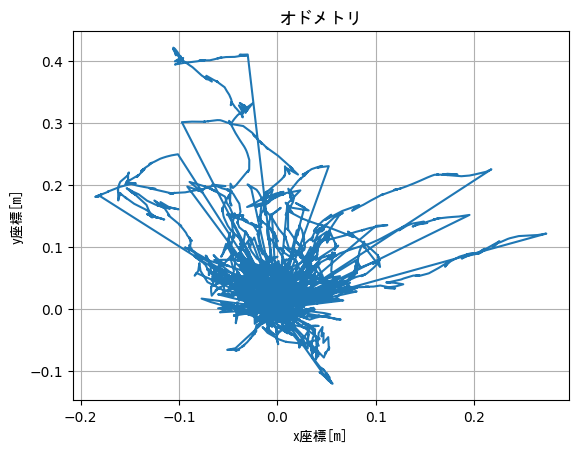

In [12]:
plt.title("オドメトリ", fontname="MS Gothic")
plt.grid()
plt.xlabel("x座標[m]", fontname="MS Gothic")
plt.ylabel("y座標[m]", fontname="MS Gothic")
plt.plot(env.mouse_ypos_graph, env.mouse_xpos_graph, linestyle='solid', label="報酬")

In [3]:
import gymnasium as gym
env = gym.make('CartPole-v1')
print(env.metadata)


{'render_modes': ['human', 'rgb_array'], 'render_fps': 50}

## env.step(action)の戻り値の更新について（４つから５つになりました）
Gymライブラリのバージョン0.26以降、及びGymnasiumの全バージョンにおいて、`env.step()`メソッドの戻り値は、以前の4要素のタプルから5要素のタプルに変更されました。これまでの`observation, reward, done, info`という形式から、`observation, reward, terminated, truncated, info`という形式になっています。

ここでの`terminated`と`truncated`はどちらもブール値（真偽値）です。`terminated`は環境がマルコフ決定過程（MDP）のタスクの定義に基づいて終了状態に達したことを示します。これは通常、環境の目標が達成されたり、終了条件が満たされたときに発生します。一方、`truncated`は、エピソードがMDPの範囲外の条件、たとえば時間制限や境界条件（エージェントが境界を越えるなど）によって終了したことを示します。強化学習アルゴリズムにおいて、特にブートストラップを伴うものでは、終了と切り捨て状態の取り扱いが値の更新において異なる場合があるため、この区別は重要です。

Gymライブラリのこの更新は、強化学習タスクにおける終了と切り捨ての明確な区別を提供するために行われました。これは、特定のアルゴリズムの正確な実装にとって重要です。終了(`terminated`)と切り捨て(`truncated`)の両方のタイプのエピソード終了を区別するために、両方が含まれるようになりました。

あなたの目的に合わせて、エピソードが終了したかどうか（理由に関係なく）を知りたい場合は、`terminated`または`truncated`のいずれかが`True`であるかどうかを確認すればよいです。その場合、環境をリセットします。

In [ ]:
# モデルのテスト
state, _ = env.reset()  # ここを修正
for i in trange(4000):
    # 環境の描画
    env.render()

    # モデルの推論
    action, _ = model.predict(state)

    # 1ステップ実行
    state, rewards, done, info = env.step(action)

    # エピソード完了
    if done:
        state, _ = env.reset()  # エピソードが終了したら、環境をリセット


In [1]:
def doc_string_example():
        """ドックストリング（Docstring）
        この関数は以下のことを行います：\n
    - param1を処理します。\n
    - param2を別の方法で処理します。\n
    最後に、結果を返します。
        シミュレーションをnフレーム進め、制御アクションを適用する。
        Step the simulation n number of frames and applying a control action.
        """
        p = 1